In [1]:
import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models
from torchvision.models import resnet50, ResNet50_Weights
from torchvision.datasets import ImageFolder
import albumentations as A
import torchvision
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
import os
import cv2
import gc
import numpy as np
import pandas as pd
import itertools
from tqdm.autonotebook import tqdm
import matplotlib.pyplot as plt
import torch
from torch import nn
import torch.nn.functional as F
import timm
from transformers import DistilBertModel, DistilBertConfig, DistilBertTokenizer
from segment_anything import build_sam, SamAutomaticMaskGenerator, sam_model_registry
from PIL import Image, ImageDraw
import clip

/ext3/miniconda3/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
transform = A.Compose(
        [
            A.Resize(224, 224, always_apply=True),
            A.Normalize(max_pixel_value=255.0, always_apply=True),
        ]
    )

In [4]:
# Set the path to your dataset folder
dataset_path = '/scratch/sg7729/DL_project/Evaluate/PokemonData'


# Define the dataset
dataset = torchvision.datasets.ImageFolder(root=dataset_path)

# Split the dataset into training and validation sets
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, test_size])


In [13]:
print(len(test_dataset))

1364


In [ ]:
sam_checkpoint = "/scratch/sg7729/DL_project/SLIP/sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

In [16]:
# Download the model weights to load them here
mask_generator = SamAutomaticMaskGenerator(
        model = sam,
        points_per_side = 16,
        pred_iou_thresh =  0.9,
        min_mask_region_area = 1,
        crop_overlap_ratio = 0.8 )

In [17]:
def convert_box_xywh_to_xyxy(box):
    """
    Convert bounding box from [x, y, w, h] format to [x1, y1, x2, y2] format.

    Args:
        box (list): Bounding box coordinates in [x, y, w, h] format.

    Returns:
        list: Bounding box coordinates in [x1, y1, x2, y2] format.
    """
    x1 = box[0]
    y1 = box[1]
    x2 = box[0] + box[2]
    y2 = box[1] + box[3]
    return [x1, y1, x2, y2]

In [18]:
def segment_image(image, segmentation_mask):
    """
    Segment an image using a binary segmentation mask.

    Args:
        image (PIL.Image.Image): Input image.
        segmentation_mask (ndarray): Binary segmentation mask.

    Returns:
        PIL.Image.Image: Segmented image with the background set to black.
    """
    image_array = np.array(image)
    segmented_image_array = np.zeros_like(image_array)
    segmented_image_array[segmentation_mask] = image_array[segmentation_mask]
    segmented_image = Image.fromarray(segmented_image_array)
    black_image = Image.new("RGB", image.size, (0, 0, 0))
    transparency_mask = np.zeros_like(segmentation_mask, dtype=np.uint8)
    transparency_mask[segmentation_mask] = 255
    transparency_mask_image = Image.fromarray(transparency_mask, mode='L')
    black_image.paste(segmented_image, mask=transparency_mask_image)
    return black_image

In [19]:
def filter_annotations(annotations):
    """
    Filter a list of annotations based on area and segmentation overlap.

    Args:
        annotations (list): List of annotation dictionaries.

    Returns:
        list: Filtered list of annotations.
    """
    annotations.sort(key=lambda x: x['area'], reverse=True)
    to_remove = set()
    for i in range(0, len(annotations)):
        a = annotations[i]
        for j in range(i + 1, len(annotations)):
            b = annotations[j]
            if i != j and j not in to_remove:
                # check if 
                if b['area'] < a['area']:
                    if (a['segmentation'] & b['segmentation']).sum() / b['segmentation'].sum() > 0.8:
                        # print('area')
                        to_remove.add(j)
#                         print(i, j)
#     print(to_remove)
    return [a for i, a in enumerate(annotations) if i not in to_remove]

In [20]:
class config:
    image_path = "/scratch/sg7729/DL_project/SLIP/Images"
    captions_path = "/scratch/sg7729/DL_project/SLIP/"
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    text_tokenizer = "distilbert-base-uncased"

In [21]:
class CLIPDataset(torch.utils.data.Dataset):
    def __init__(self, image_filenames, captions, tokenizer, transforms):
        """
        Initializes a CLIPDataset object.

        Args:
            image_filenames (list): List of image filenames.
            captions (list): List of captions corresponding to the images.
            tokenizer (transformers.tokenization_utils_base.PreTrainedTokenizer):
                Tokenizer object used to tokenize the captions.
            transforms (torchvision.transforms.Compose): Image transformations to be applied.

        Note:
            - `image_filenames` and `captions` must have the same length.
              If there are multiple captions for each image, the `image_filenames` list
              must have repetitive file names.

        """

        self.image_filenames = image_filenames # one description per image
        self.captions = list(captions) # one description per image
        self.encoded_captions = tokenizer(
            list(captions), padding=True, truncation=True, max_length=200
        )
        self.transforms = transforms

    def __getitem__(self, idx):
        """
        Retrieves an item from the dataset.

        Args:
            idx (int): Index of the item to retrieve.

        Returns:
            dict: A dictionary containing the encoded caption, image tensor,
                    and the original caption.

        """
        item = {
            key: torch.tensor(values[idx])
            for key, values in self.encoded_captions.items()
        }

        item['image'] = [1]
        item['caption'] = self.captions[idx]

        return item


    def __len__(self):
        """
        Returns the length of the dataset.

        Returns:
            int: Length of the dataset.

        """
        return len(self.captions)

In [22]:
class ImageEncoder(nn.Module):
    """
    Encode images to a fixed-size vector.

    Args:
        model_name (str): Name of the image encoder model. Default is 'resnet50'.
        pretrained (bool): Whether to use pretrained weights for the model. Default is True.
        trainable (bool): Whether to make the model trainable. Default is True.

    Attributes:
        model (torchvision.models.ResNet): Image encoder model.
    
    """

    def __init__(
        self, model_name='resnet50', pretrained=True, trainable=True
    ):
        """
        Initializes an ImageEncoder object.

        Args:
            model_name (str): Name of the image encoder model. Default is 'resnet50'.
            pretrained (bool): Whether to use pretrained weights for the model. Default is True.
            trainable (bool): Whether to make the model trainable. Default is True.

        """ 
        super().__init__()
        self.model = timm.create_model(
            model_name, pretrained, num_classes=0, global_pool="avg"
        )
        for p in self.model.parameters():
            p.requires_grad = trainable

    def forward(self, x):
        """
        Forward pass of the ImageEncoder.

        Args:
            x (torch.Tensor): Input images to be encoded.

        Returns:
            torch.Tensor: Encoded image representation.

        """
        return self.model(x)

In [23]:
def make_train_valid_dfs():
    """
    Create train and validation dataframes from a captions CSV file.

    Returns:
        pandas.DataFrame: Train dataframe containing a subset of the captions.
        pandas.DataFrame: Validation dataframe containing a subset of the captions.

    """
    dataframe = pd.read_csv(f"{config.captions_path}/captions.csv")
    max_id = dataframe["id"].max() + 1
    image_ids = np.arange(0, max_id)
    np.random.seed(42)
    valid_ids = np.random.choice(
        image_ids, size=int(0.2 * len(image_ids)), replace=False
    )
    train_ids = [id_ for id_ in image_ids if id_ not in valid_ids]
    train_dataframe = dataframe[dataframe["id"].isin(train_ids)].reset_index(drop=True)
    valid_dataframe = dataframe[dataframe["id"].isin(valid_ids)].reset_index(drop=True)
    return train_dataframe, valid_dataframe


def build_loaders(dataframe, tokenizer, mode):
    """
    Build data loaders for training or validation using the given dataframe and tokenizer.

    Args:
        dataframe (pandas.DataFrame): Dataframe containing image and caption data.
        tokenizer: Tokenizer object for encoding the captions.
        mode (str): Mode of the data loader. Options: 'train' or 'valid'.

    Returns:
        torch.utils.data.DataLoader: Data loader for the specified mode.

    """
    transforms = A.Compose(
        [
            A.Resize(224, 224, always_apply=True),
            A.Normalize(max_pixel_value=255.0, always_apply=True),
        ]
    )
    dataset = CLIPDataset(
        dataframe["image"].values,
        dataframe["caption"].values,
        tokenizer=tokenizer,
        transforms=transforms,
    )
    dataloader = torch.utils.data.DataLoader(
        dataset,
        batch_size=32,
        num_workers=2,
        shuffle=True if mode == "train" else False,
    )
    return dataloader

class AvgMeter:
    """
    Computes and tracks the average value of a metric.

    Args:
        name (str): Name of the metric. Default is "Metric".

    Attributes:
        name (str): Name of the metric.
        avg (float): Average value of the metric.
        sum (float): Sum of the metric values.
        count (int): Number of metric values.

    """
    def __init__(self, name="Metric"):
        """
        Initializes an AvgMeter object.

        Args:
            name (str): Name of the metric. Default is "Metric".

        """
        self.name = name
        self.reset()

    def reset(self):
        """
        Resets the metric values to zero.

        """
        self.avg, self.sum, self.count = [0] * 3

    def update(self, val, count=1):
        """
        Updates the metric values with the given value.

        Args:
            val (float): Value to update the metric with.
            count (int): Number of occurrences of the value. Default is 1.

        """
        self.count += count
        self.sum += val * count
        self.avg = self.sum / self.count

    def __repr__(self):
        """
        Returns a string representation of the metric.

        Returns:
            str: String representation of the metric in the format "Name: Average".

        """
        text = f"{self.name}: {self.avg:.4f}"
        return text

def get_lr(optimizer):
    """
    Get the learning rate of the optimizer.

    Args:
        optimizer: Optimizer object.

    Returns:
        float: Learning rate.

    """
    for param_group in optimizer.param_groups:
        return param_group["lr"]

In [24]:
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
train_df, valid_df = make_train_valid_dfs()
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
train_loader = build_loaders(train_df, tokenizer, mode="train")
valid_loader = build_loaders(valid_df, tokenizer, mode="valid")


In [25]:
class TextEncoder(nn.Module):
    """
    Encode text input to a fixed-size vector representation.

    Args:
        model_name (str): Name of the text encoder model. Default is "distilbert-base-uncased".
        pretrained (bool): Whether to use pretrained weights for the model. Default is True.
        trainable (bool): Whether to make the model trainable. Default is True.

    Attributes:
        model (transformers.DistilBertModel): Text encoder model.
        target_token_idx (int): Index of the target token used for sentence embedding.

    """

    def __init__(self, model_name="distilbert-base-uncased", pretrained=True, trainable=True):
        """
        Initializes a TextEncoder object.

        Args:
            model_name (str): Name of the text encoder model. Default is "distilbert-base-uncased".
            pretrained (bool): Whether to use pretrained weights for the model. Default is True.
            trainable (bool): Whether to make the model trainable. Default is True.

        """
        super().__init__()
        if pretrained:
            self.model = DistilBertModel.from_pretrained(model_name)
        else:
            self.model = DistilBertModel(config=DistilBertConfig())
            
        for p in self.model.parameters():
            p.requires_grad = trainable

        # we are using the CLS token hidden representation as the sentence's embedding
        self.target_token_idx = 0

    def forward(self, input_ids, attention_mask):
        """
        Forward pass of the TextEncoder.

        Args:
            input_ids (torch.Tensor): Input token IDs.
            attention_mask (torch.Tensor): Attention mask indicating which tokens to attend to.

        Returns:
            torch.Tensor: Encoded text representation.

        """
        output = self.model(input_ids=input_ids, attention_mask=attention_mask)
        last_hidden_state = output.last_hidden_state
        return last_hidden_state[:, self.target_token_idx, :]

In [26]:
class ProjectionHead(nn.Module):
    """
    Projection head for projecting the input embeddings to a lower-dimensional space.

    Args:
        embedding_dim (int): Dimensionality of the input embeddings.
        projection_dim (int): Dimensionality of the projected embeddings. Default is 256.
        dropout (float): Dropout probability. Default is 0.

    Attributes:
        projection (torch.nn.Linear): Linear projection layer.
        gelu (torch.nn.GELU): GELU activation function.
        fc (torch.nn.Linear): Fully connected layer.
        dropout (torch.nn.Dropout): Dropout layer.
        layer_norm (torch.nn.LayerNorm): Layer normalization layer.

    """
    def __init__(
        self,
        embedding_dim,
        projection_dim=128,
        dropout=0
    ):
        """
        Initializes a ProjectionHead object.

        Args:
            embedding_dim (int): Dimensionality of the input embeddings.
            projection_dim (int): Dimensionality of the projected embeddings. Default is 256.
            dropout (float): Dropout probability. Default is 0.

        """
        super().__init__()
        self.projection = nn.Linear(embedding_dim, projection_dim)
        self.gelu = nn.GELU()
        self.fc = nn.Linear(projection_dim, projection_dim)
        self.dropout = nn.Dropout(dropout)
        self.layer_norm = nn.LayerNorm(projection_dim)
    
    def forward(self, x):
        """
        Forward pass of the ProjectionHead.

        Args:
            x (torch.Tensor): Input embeddings to be projected.

        Returns:
            torch.Tensor: Projected embeddings.

        """
        projected = self.projection(x)
        x = self.gelu(projected)
        x = self.fc(x)
        x = self.dropout(x)
        x = x + projected
        x = self.layer_norm(x)
        return x

In [27]:
class CLIPModel(nn.Module):
    """
    Contrastive Language-Image Pretraining (CLIP) model.

    Args:
        temperature (float): Temperature parameter for the contrastive loss. Default is 1.
        image_embedding (int): Dimensionality of the image embeddings. Default is 2048.
        text_embedding (int): Dimensionality of the text embeddings. Default is 768.
        projection_dim (int): Dimensionality of the projected embeddings. Default is 256.

    Attributes:
        image_encoder (ImageEncoder): Image encoder module.
        text_encoder (TextEncoder): Text encoder module.
        image_projection (ProjectionHead): Projection head for image embeddings.
        text_projection (ProjectionHead): Projection head for text embeddings.
        temperature (float): Temperature parameter for the contrastive loss.

    """
    def __init__(
        self,
        temperature=1,
        image_embedding=2048,
        text_embedding=768,
    ):
        """
        Initializes a CLIPModel object.

        Args:
            temperature (float): Temperature parameter for the contrastive loss. Default is 1.
            image_embedding (int): Dimensionality of the image embeddings. Default is 2048.
            text_embedding (int): Dimensionality of the text embeddings. Default is 768.
            projection_dim (int): Dimensionality of the projected embeddings. Default is 256.

        """
        super().__init__()
        self.image_encoder = ImageEncoder()
        self.text_encoder = TextEncoder()
        self.image_projection = ProjectionHead(embedding_dim=image_embedding)
        self.text_projection = ProjectionHead(embedding_dim=text_embedding)
        self.temperature = temperature

    def forward(self, batch):
        """
        Forward pass of the CLIPModel.

        Args:
            batch (dict): Dictionary containing input data (image, input_ids, attention_mask).

        Returns:
            torch.Tensor: Mean contrastive loss for the batch.

        """
        # Getting Image and Text Features
        image_features = self.image_encoder(batch["image"])
        text_features = self.text_encoder(
            input_ids=batch["input_ids"], attention_mask=batch["attention_mask"]
        )
        # Getting Image and Text Embeddings (with same dimension)
        image_embeddings = self.image_projection(image_features)
        text_embeddings = self.text_projection(text_features)

        # Calculating the Loss
        batch_size = len(image_embeddings) 
        logits = (text_embeddings @ image_embeddings.T) / self.temperature
        images_similarity = image_embeddings @ image_embeddings.T
        texts_similarity = text_embeddings @ text_embeddings.T
        targets = F.softmax(
            (images_similarity + texts_similarity) / 2 * self.temperature, dim=-1
        )
        texts_loss = cross_entropy(logits, targets, reduction='none')
        images_loss = cross_entropy(logits.T, targets.T, reduction='none')
        loss =  (images_loss + texts_loss) / 2.0 # shape: (batch_size)
        return loss.mean()


def cross_entropy(preds, targets, reduction='none'):
    """
    Compute the cross-entropy loss between predicted logits and target probabilities.

    Args:
        preds (torch.Tensor): Predicted logits.
        targets (torch.Tensor): Target probabilities.
        reduction (str): Specifies the reduction to apply to the loss. 
                         Options: 'none' (no reduction), 'mean' (mean of the losses).
                         Default is 'none'.

    Returns:
        torch.Tensor: Cross-entropy loss.

    """
    log_softmax = nn.LogSoftmax(dim=-1)
    loss = (-targets * log_softmax(preds)).sum(1)
    if reduction == "none":
        return loss
    elif reduction == "mean":
        return loss.mean()

In [28]:
def get_masks_embeddings(model, masks): 
    """
    Obtain embeddings for a list of masks using a given model.

    Args:
        model: The model used for generating embeddings.
        masks (list): List of mask images.

    Returns:
        torch.Tensor: Concatenated mask image embeddings.
    """ 
    model.eval()
    # Apply transforms
    transforms = A.Compose(
        [
            A.Resize(224, 224, always_apply=True),
            A.Normalize(max_pixel_value=255.0, always_apply=True),
        ],
    )

    
    processed_masks = []
    
    for mask in masks:
#         print(mask)
        mask = np.array(mask)
#         print(mask.shape)
        mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
        mask = transforms(image=mask)['image']
        mask = np.transpose(mask, (2, 0, 1))
#         print(mask.shape)
        processed_masks.append(mask)
        
    processed_masks = torch.tensor(processed_masks)
    print(processed_masks.shape)

    mask_image_embeddings = []
    with torch.no_grad():
        image_features = model.image_encoder(processed_masks.to(device))
        image_embeddings = model.image_projection(image_features)
        mask_image_embeddings.append(image_embeddings)
    return torch.cat(mask_image_embeddings)

In [29]:
def find_matching_masks(model, image_embeddings, query, n=9):
    """
    Find matching masks based on a given query using image and text embeddings.

    Args:
        model: The model used for generating embeddings.
        image_embeddings (torch.Tensor): Image embeddings.
        query (str): The query used for matching.
        n (int): Number of matching masks to retrieve (default: 9).

    Returns:
        torch.Tensor: Dot product similarity matrix.
        torch.Tensor: Top-k values of the similarity matrix.
    """
    tokenizer = DistilBertTokenizer.from_pretrained(config.text_tokenizer)
    encoded_query = tokenizer([query])
    batch = {
        key: torch.tensor(values).to(config.device)
        for key, values in encoded_query.items()
    }
    with torch.no_grad():
        text_features = model.text_encoder(
            input_ids=batch["input_ids"], attention_mask=batch["attention_mask"]
        )
        text_embeddings = model.text_projection(text_features)
    
    image_embeddings_n = F.normalize(image_embeddings, p=2, dim=-1)
    text_embeddings_n = F.normalize(text_embeddings, p=2, dim=-1)
    dot_similarity = text_embeddings_n @ image_embeddings_n.T
    
    values, indices = torch.topk(dot_similarity.squeeze(0), 1)
    print(dot_similarity)
    return dot_similarity, values

In [30]:
model = CLIPModel().to(device)
model.load_state_dict(torch.load('/scratch/sg7729/DL_project/SLIP/TrainL_Metric: 0.3710_ValidL_Metric: 0.7791_Epoch_99.pt'))

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_projector.weight', 'vocab_transform.weight', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


<All keys matched successfully>

In [31]:
def get_text_embeddings(model, valid_loader, tokenizer):
    """
    Computes the text embeddings of captions using a language model.

    Args:
        model (torch.nn.Module): The language model used for text encoding.
        valid_loader (torch.utils.data.DataLoader): The data loader containing the captions.
        tokenizer: The tokenizer used to encode the captions.

    Returns:
        torch.Tensor: The text embeddings of the captions.

    """
  
    model.eval()

    valid_text_embeddings = []
    with torch.no_grad():
        for batch in tqdm(valid_loader):
            encoded = tokenizer(batch['caption'])
            text_features = model.text_encoder(
                      input_ids=batch["input_ids"].to(config.device), attention_mask=batch["attention_mask"].to(config.device)
            )
            text_embeddings = model.text_projection(text_features)
            valid_text_embeddings.append(text_embeddings)
  
    return torch.cat(valid_text_embeddings)

In [32]:
def find_matching_text(model, text_embeddings, query, captions, n=1):
    """
    Finds the captions that match the given query text.

    Args:
        model (torch.nn.Module): The model used for matching.
        text_embeddings (torch.Tensor): The text embeddings of the captions.
        query (torch.Tensor): The text embedding of the query text.
        captions (list): The list of captions.
        n (int): The number of matching captions to retrieve.

    Returns:
        str: The matching caption.

    """
    with torch.no_grad():
        query = torch.unsqueeze(query, 0)
        image_features = model.image_encoder(query.to(config.device))
        image_embeddings = model.image_projection(image_features)

        image_embeddings_n = F.normalize(image_embeddings, p=2, dim=-1)
        text_embeddings_n = F.normalize(text_embeddings, p=2, dim=-1)
        dot_similarity = image_embeddings_n @ text_embeddings_n.T
        values, indices = torch.topk(dot_similarity, n * 5)

        matches = [captions[idx] for idx in indices.cpu()[::5]][0]

    return matches[0]


In [33]:
text_embeddings = get_text_embeddings(model, valid_loader, tokenizer)

100%|██████████| 67/67 [00:04<00:00, 14.16it/s]


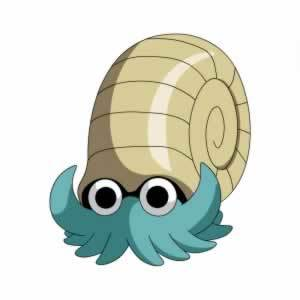

In [34]:
img, lable = test_dataset[25]
img

In [25]:
img = np.array(img) 
masks = mask_generator.generate(img)
print(len(masks))
new_annotaions = filter_annotations(masks)
print(len(new_annotaions))

61
43


In [ ]:
cropped_boxes = []
for mask in new_annotaions:
    cropped_boxes.append(segment_image(img, mask["segmentation"]).crop(convert_box_xywh_to_xyxy(mask["bbox"])))

In [ ]:
cropped_boxes[5]

In this code, we are evaluating the performance of the CLIP model on a test dataset. We iterate through each image in the dataset, preprocess it, and convert it into a tensor. Using the find_matching_text function, we predict the text that corresponds to each image based on a set of captions. If the predicted text matches the true label of the image, we increment the correct variable; otherwise, we add the image to the wrong list. We also print the accuracy after processing every 50 images. Finally, we display the overall accuracy of the model on the entire dataset.

In [43]:

# Evaluate CLIP

# Loop through the test dataest and generate masks for each image
correct = 0
wrong = []
class_names = dataset.classes
for i in range(len(dataset)):
    img, label = dataset[i]
    open_cv_image = np.array(img) 
    transform = A.Compose(
        [
            A.Resize(224, 224, always_apply=True),
            A.Normalize(max_pixel_value=255.0, always_apply=True),
        ]
    ) 
    open_cv_image = cv2.cvtColor(open_cv_image, cv2.COLOR_BGR2RGB)
    open_cv_image = transform(image=open_cv_image)['image']
    open_cv_image = np.transpose(open_cv_image, (2, 0, 1))
    image_tensor = torch.tensor(open_cv_image)

    text_predicted = find_matching_text(model, text_embeddings, query=image_tensor, captions=valid_df['caption'].values)
    if class_names[label].lower() in text_predicted.lower():
        correct += 1
    
    else:
        wrong.append(img)

    if i % 50 == 0:
        print(f"Accuracy after {i + 1} images: {correct / (i + 1)}")
    
    

print(f"Final accuracy: {correct / len(dataset)}")


Accuracy after 1 images: 0.0
Accuracy after 51 images: 0.4117647058823529
Accuracy after 101 images: 0.37623762376237624
Accuracy after 151 images: 0.33774834437086093
Accuracy after 201 images: 0.4228855721393035
Accuracy after 251 images: 0.3944223107569721
Accuracy after 301 images: 0.45514950166112955
Accuracy after 351 images: 0.5242165242165242
Accuracy after 401 images: 0.5835411471321695
Accuracy after 451 images: 0.623059866962306
Accuracy after 501 images: 0.6586826347305389
Accuracy after 551 images: 0.6551724137931034
Accuracy after 601 images: 0.627287853577371
Accuracy after 651 images: 0.6036866359447005
Accuracy after 701 images: 0.62339514978602
Accuracy after 751 images: 0.6364846870838882
Accuracy after 801 images: 0.6454431960049938
Accuracy after 851 images: 0.6474735605170387
Accuracy after 901 images: 0.6648168701442841
Accuracy after 951 images: 0.6803364879074658
Accuracy after 1001 images: 0.6543456543456544
Accuracy after 1051 images: 0.6517602283539486
Accur

## 